# ネットワークモチーフ解析
大腸菌の遺伝子制御ネットワークを例にして，ネットワークモチーフ解析を行います。 + ネットワークモチーフを見つける。 + 部分ネットワーク・プロファイルを計算する。

# ネットワークモチーフを見つける

In [89]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

## ~~大腸菌の遺伝子制御ネットワークの読み込み~~

* `../data/ecoli_regDB5.txt`
* エッジリスト形式
* Salgado H et al. (2006) RegulonDB (version 5.0): Escherichia coli K-12 transcriptional regulatory network, operon organization, and growth conditions. Nucleic Acids Res., 34, pp. D394–D397. https://doi.org/10.1093/nar/gkj156

**実行速度の関係から他のネットワークを使用**


In [43]:

d = pd.read_csv("../data/terrestrial_food_web_caribbean.txt", header=None,names=["source", "target"], sep="\t| ", engine='python')
g = nx.from_pandas_edgelist(d, edge_attr=None, create_using=nx.DiGraph())
Gcc = sorted(nx.weakly_connected_components(g), key=len, reverse=True)
G = g.subgraph(Gcc[0])
G = nx.DiGraph(G)
G.remove_edges_from(nx.selfloop_edges(G))




## 現実のネットワークの3ノードで構成される部分ネットワークの出現頻度を計算

In [39]:
# TODO: fix hard coding
motifs_3 = {
    'S1': nx.DiGraph([(2,1),(2,3)]),
    'S2': nx.DiGraph([(2,1),(3,2)]),
    'S3': nx.DiGraph([(2,1),(2,3), (3,2)]),
    'S4': nx.DiGraph([(2,1), (3,1)]),
    'S5': nx.DiGraph([(2,1),(3,1),(2,3)]),
    'S6': nx.DiGraph([(2,1),(3,1),(2,3),(3,2)]),
    'S7': nx.DiGraph([(1,2),(2,3),(3,2)]),
    'S8': nx.DiGraph([(1,2),(2,1),(2,3), (3,2)]),
    'S9': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S10': nx.DiGraph([(1,2),(2,1),(2,3),(3,1)]),
    'S11': nx.DiGraph([(1,2),(2,1),(3,1),(3,2)]),
    'S12': nx.DiGraph([(1,2),(2,1),(2,3),(3,1),(3,2)]),
    'S13': nx.DiGraph([(1,2),(2,1),(2,1),(2,3),(3,1),(3,2)]),
    }

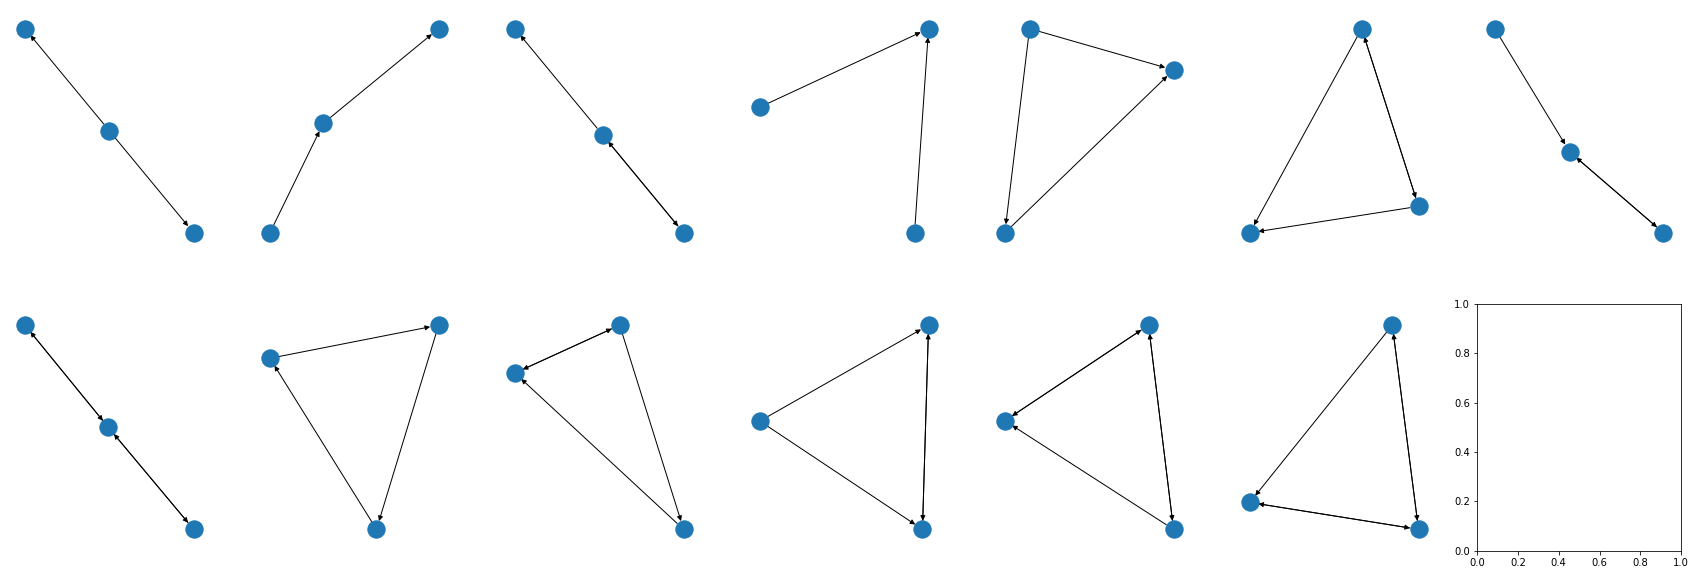

In [40]:
fig, ax = plt.subplots(2, 7, figsize=(30, 10))
for i in range(13):
    nx.draw(motifs_3[f"S{i+1}"], ax=ax[int(i/7)][i%7])

In [44]:
num_of_nodes = 3 
subgraphs = [] 
for nodes in itertools.combinations(G.nodes, num_of_nodes):
    G_sub = G.subgraph(nodes) 
    if nx.is_weakly_connected(G_sub):
        subgraphs.append(G_sub)
        


In [49]:
motif_real = list(map(int, np.zeros(len(motifs_3))))
for sub in subgraphs:
     mot_match = list(map(lambda mot_id: int(nx.is_isomorphic(sub, motifs_3[mot_id])), motifs_3.keys()))
     mot_id = np.argmax(mot_match)
     motif_real[mot_id] += 1


In [62]:
motif_rand = [[] for i in range(len(motifs_3))]

din=[d for n, d in G.in_degree()]
dout=[d for n, d in G.out_degree()]

for i in range(100):
    subgraphs = [] 
    motif_cnt = list(map(int, np.zeros(len(motifs_3))))
    G_rand=nx.directed_configuration_model(din,dout)

    for nodes in itertools.combinations(G_rand.nodes, num_of_nodes):
        G_sub = G_rand.subgraph(nodes) 
        if nx.is_weakly_connected(G_sub):
            subgraphs.append(G_sub)

    for sub in subgraphs:
        mot_match = list(map(lambda mot_id: int(nx.is_isomorphic(sub, motifs_3[mot_id])), motifs_3.keys()))
        mot_id = np.argmax(mot_match)
        motif_cnt[mot_id] += 1

    for i in range(len(motifs_3)):
        motif_rand[i].append(motif_cnt[i])

    


## Zスコアの計算

In [69]:
z_motif = (motif_real - np.mean(motif_rand, axis=1)) / np.std(motif_rand, axis=1)


<ipython-input-69-05e0e7c15157>:1: RuntimeWarning: invalid value encountered in true_divide
  z_motif = (motif_real - np.mean(motif_rand, axis=1)) / np.std(motif_rand, axis=1)


In [70]:
z_motif

array([-1.9158251 ,  6.87768552, -1.41446714,  5.91219491, 14.19459198,
       -1.01153441, -1.49996291, -0.59620205, -1.33978769, -0.88042486,
       -0.91044025, -0.41394695,         nan])

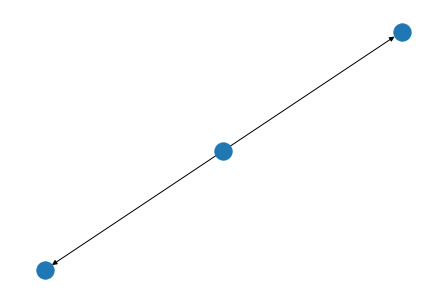

In [71]:
nx.draw(motifs_3["S1"])

## P値を計算する（両側検定）

In [74]:
p_motif = 2 * stats.norm.cdf(-abs(z_motif))
p_motif


array([5.53873620e-02, 6.08327754e-12, 1.57224790e-01, 3.37578737e-09,
       9.89607418e-46, 3.11760722e-01, 1.33624009e-01, 5.51040257e-01,
       1.80314379e-01, 3.78629196e-01, 3.62590377e-01, 6.78912961e-01,
                  nan])

## ネットワークモチーフを構成するノード集合を得る。

In [82]:
# pass

## 部分ネットワーク・プロファイルを計算する
### 有意性プロファイルを計算する


In [83]:
z_motif

array([-1.9158251 ,  6.87768552, -1.41446714,  5.91219491, 14.19459198,
       -1.01153441, -1.49996291, -0.59620205, -1.33978769, -0.88042486,
       -0.91044025, -0.41394695,         nan])

In [85]:
z_motif_na_omit = z_motif[~np.isnan(z_motif)]
tsp = z_motif_na_omit / np.sqrt(np.sum(z_motif_na_omit**2))

<BarContainer object of 12 artists>

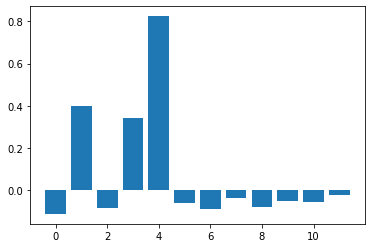

In [113]:
# label = [x for x in motifs_3.keys()] 
plt.bar(range(len(tsp)), tsp, align="center", width=0.8)


## 部分ネットワーク比率プロファイルの計算

In [109]:
# 相対部分ネットワーク比の計算
tsr_motif = (motif_real - np.mean(motif_rand, axis=1)) / (motif_real + np.mean(motif_rand, axis=1) + 4)

# NAを削除する
tsr_motif_na_omit = tsr_motif[~np.isnan(tsr_motif)]
# 標準化
tsrp_motif = tsr_motif_na_omit / np.sqrt(np.sum(tsr_motif_na_omit**2))

<BarContainer object of 13 artists>

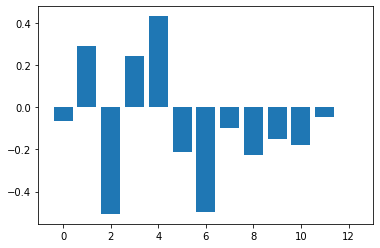

In [114]:
plt.bar(range(len(tsrp_motif)), tsrp_motif, align="center", width=0.8)